In [ ]:
from functions.functions import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from functions.functions_time_model import *

#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.training import BasicLoggerCallback

In [2]:
from seed_utilis import *

seed=1
set_seed(seed) 

In [3]:
# Define parameters
n = 4  # Number of particles
num_states = 5000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
hidden_channels=64
input_t=15
output_t=10
modes= input_t//2
proj_lift_channel= 256
epochs=200
lr=1e-3



In [4]:
J_min = -2  # min value for J
J_max = 2   # max value for J
Jx = np.random.uniform(J_min, J_max)
Jy = np.random.uniform(J_min, J_max)
Jz = np.random.uniform(J_min, J_max)
h= np.random.uniform(J_min, J_max)
print(Jx,Jy,Jz,h)

hamiltonian= construct_hamiltonian(n,Jx,Jy,Jz,h)

-0.331911981189704 0.8812979737686324 -1.9995425007306205 -0.7906697094726409


In [5]:
#hamiltonian= construct_hamiltonian(n)
time=0.314
steps =100
dataset=create_time_data_set(n,num_states,hamiltonian,time,steps)

In [18]:
train_loader,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([4000, 18, 15]), y_train: torch.Size([4000, 16, 15])
[Dataset] x_test: torch.Size([1000, 18, 15]), y_test: torch.Size([1000, 16, 15])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2**n+2,
        out_channels=2**n,
        Complex=True,
        n_layers=4,
        lifting_channels=proj_lift_channel,
        projection_channels=proj_lift_channel,
        arch_no=2)
model = model.to('cuda')

In [20]:
total_params =count_model_params(model)
print(f"Total number of parameters in FNO1D: {total_params}")

Total number of parameters in FNO1D: 346528


In [21]:

#optimizer = torch.optim.SGD(model.parameters(),lr=10e-3,momentum=0.9,weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.995)

In [22]:

l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2,reductions=['sum','mean']) 
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0, 1])
    return loss.real

train_loss = h1loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss,'mse':mse_loss}

In [23]:
import wandb
    
config = { 
    "No_of_particles": n,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_2"
name="fno_random_4"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,
    )

In [24]:
device='cuda'

callbacks = [
    BasicLoggerCallback(wandb_init_args)
]
trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: fs1132429 (fs1132429_). Use `wandb login --relogin` to force relogin


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 4000 samples
Testing on [1000] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 16, 15])
[0] time=1.68, avg_loss=0.8292, train_err=26.5339, test_loader_h1=0.4565, test_loader_l2=0.5563, test_loader_mse=0.5587
[1] time=1.28, avg_loss=0.2780, train_err=8.8944, test_loader_h1=0.1320, test_loader_l2=0.1376, test_loader_mse=0.0133
[2] time=1.28, avg_loss=0.1118, train_err=3.5773, test_loader_h1=0.1001, test_loader_l2=0.1099, test_loader_mse=0.0087
[3] time=1.28, avg_loss=0.0917, train_err=2.9336, test_loader_h1=0.0884, test_loader_l2=0.1001, test_loader_mse=0.0071
[4] time=1.28, avg_loss=0.0815, train_err=2.6090, test_loader_h1=0.0806, test_loader_l2=0.0933, test_loader_mse=0.0062
[5] time=1.28, avg_loss=0.0764, train_err=2.4454, test_loader_h1=0.0721, test_loader_l2=0.0812, test_loader_mse=

{'test_loader_h1': 0.009615248814225198,
 'test_loader_l2': 0.009887175686657429,
 'test_loader_mse': 6.54023151146248e-05}

[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])


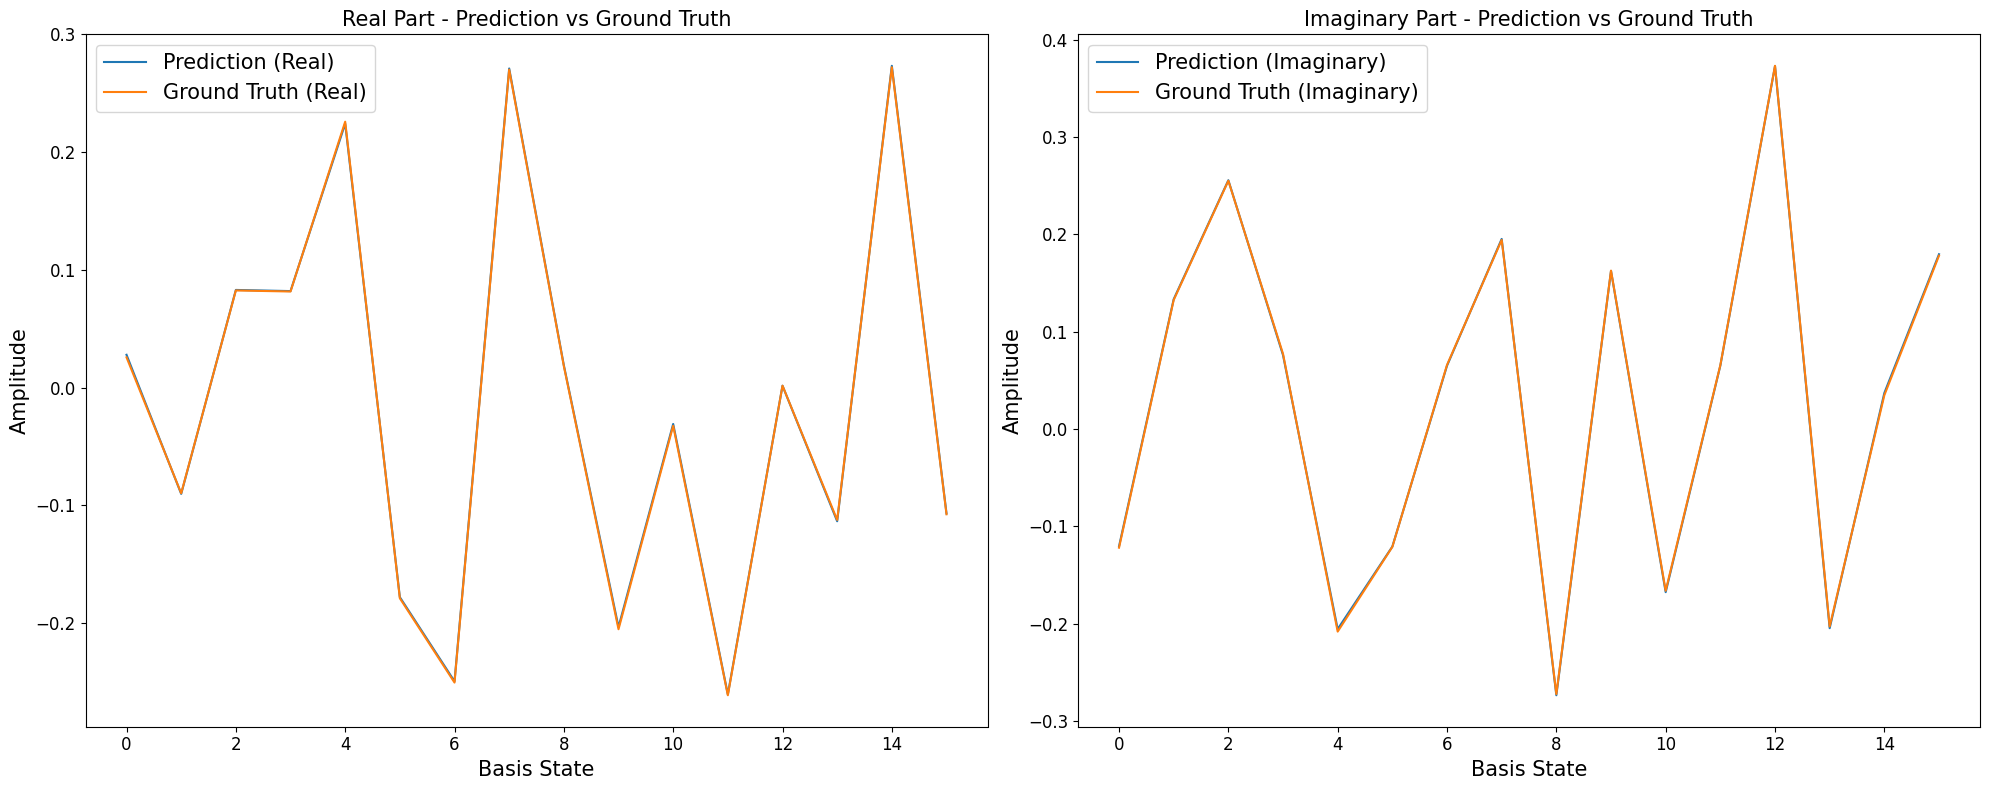

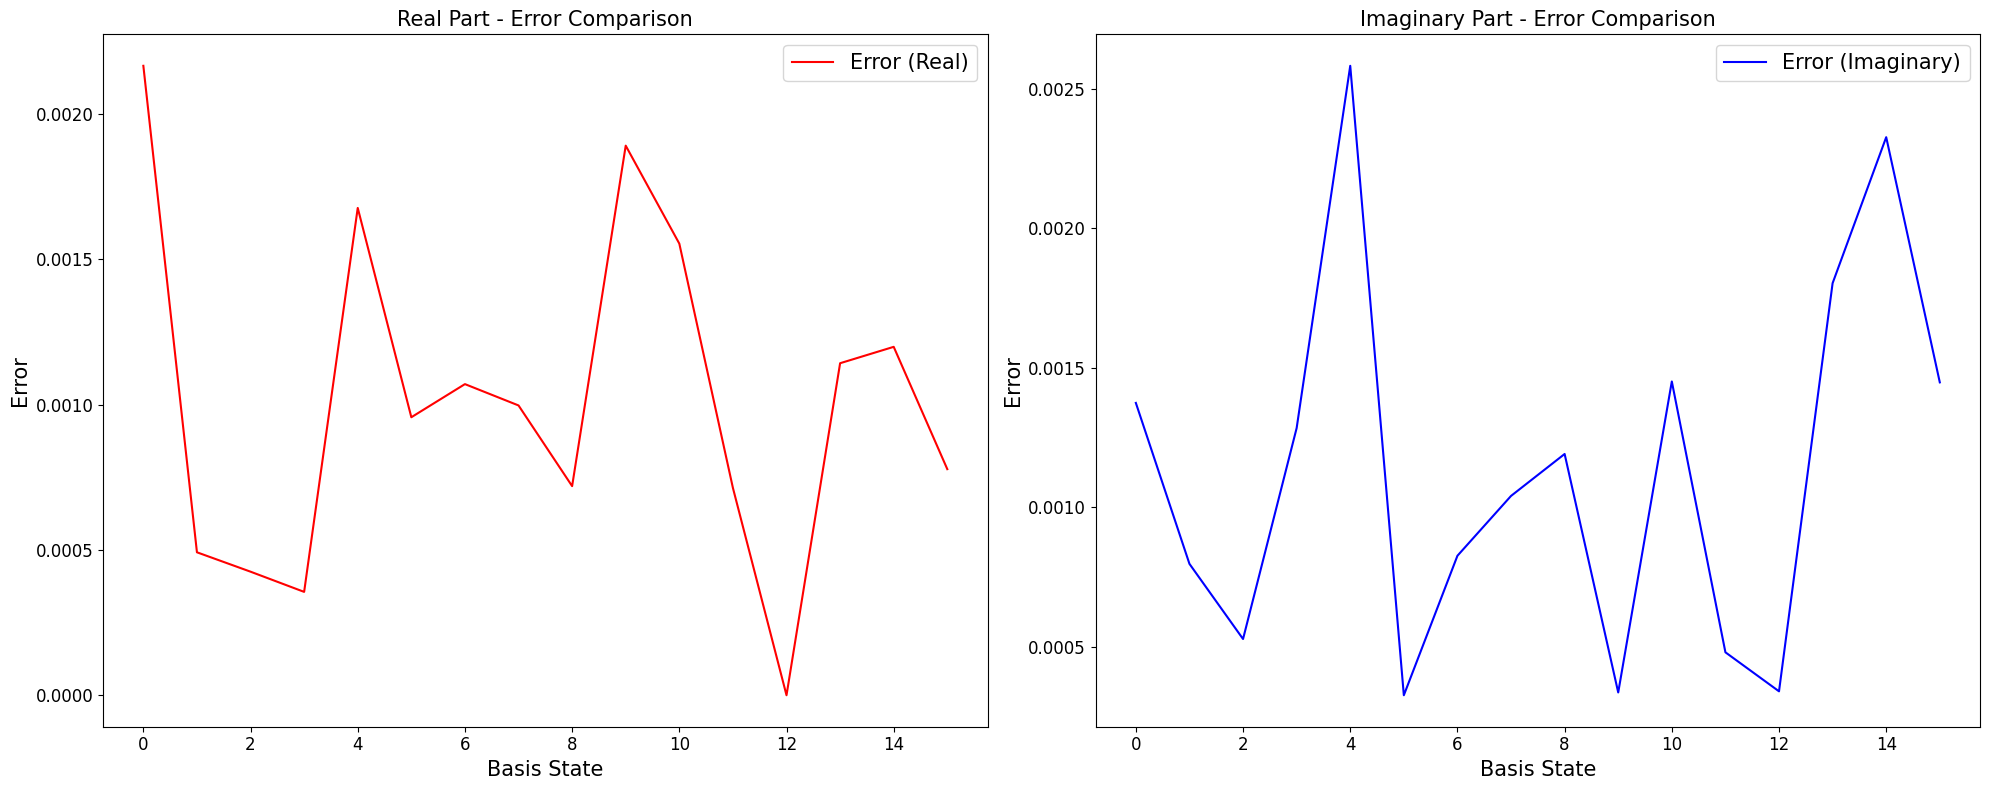

In [25]:
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

dataset=create_time_data_set(n,num_states,hamiltonian,time,steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

# Plot the comparison with error
plot_comparison_with_error2(predictions[0,:,1], ground_truth[0,:,1])  # Plot for the first sample in the dataset


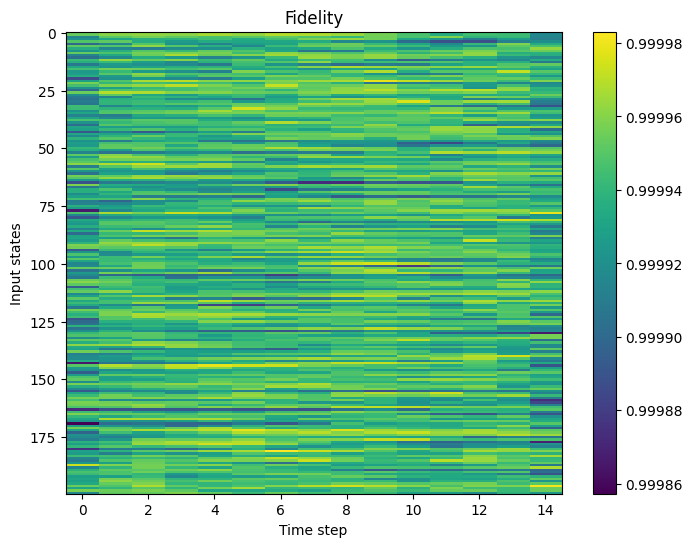

In [26]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

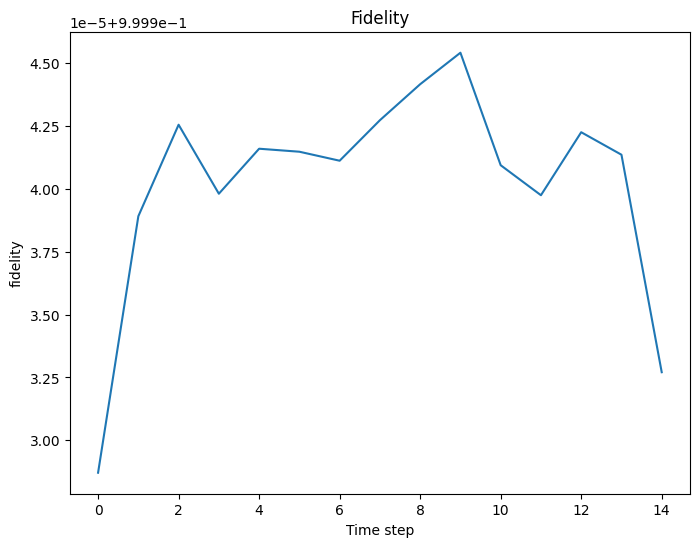

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [29]:
print(torch.mean(avg))

tensor(0.9999)


## Autoregressive rollout

In [30]:
# Example usage
from neuralop.layers.embeddings import PositionalEmbedding

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps
times=0.314
spatial_grid = torch.linspace(0, 1, 2**n).unsqueeze(0).expand(batch_size, -1).cuda()
#hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h)
steps=200

start_index=0
timesteps = torch.linspace(start_index, start_index+input_t,input_t)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)

dataset=create_time_data_set(n,num_states,hamiltonian,times, steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
train_size = int(train_ratio * num_states)
dataset1=dataset[train_size:,:,:]
predictions, ground_truth = autoregressive_rollout2(model,test_loader, dataset1,rollout_steps,pos.cuda(),output_t,input_t,overlap=True)


[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])
torch.Size([200, 16, 100])
torch.Size([200, 16, 100])


In [31]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
print(predictions.shape)
print(ground_truth.shape)

torch.Size([200, 16, 100])
torch.Size([200, 16, 100])


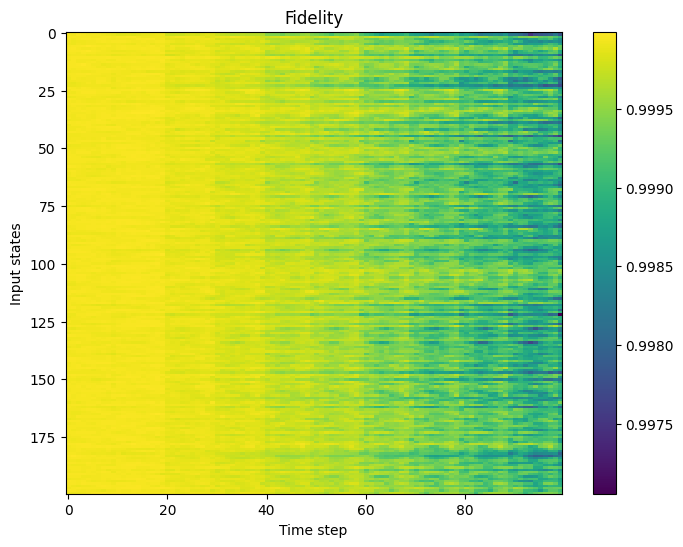

In [32]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

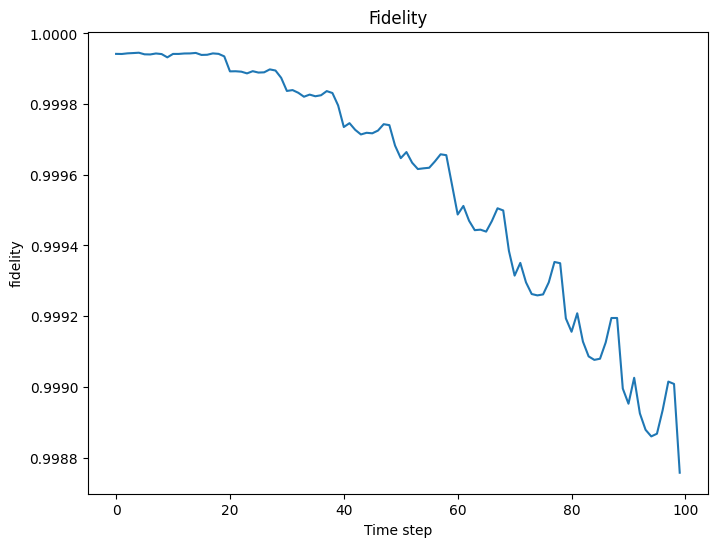

In [33]:

plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [35]:
print(torch.mean(avg))

tensor(0.9996)
tensor(0.0003)
